In [1]:
# aim : predict earnings for foreign movies in the US
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import scraping
import constants
import os
import numpy as np
import re
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from seaborn import plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection  import KFold
from sklearn import preprocessing

import scipy.stats as stats
import patsy
import statsmodels.api as sm
%matplotlib inline

In [2]:
df = pd.read_csv('data/data.csv', index_col=0)

# Data Cleaning

In [3]:

# Not enough data on these features
df = df.drop(['orb', 'tov', 'pf'], axis=1)

In [4]:
df['per'] = pd.to_numeric(df['per'], errors='force')

In [5]:
df.loc[df.weight_lb.str.isnumeric() == False, 'weight_lb'] = np.nan

In [6]:
df.weight_lb = pd.to_numeric(df.weight_lb,errors='ignore')

In [7]:
df.loc[(df.height_in==0), 'height_in'] = np.nan
df.loc[(df.wingspan_in==0), 'wingspan_in'] = np.nan
df.loc[(df.reach_in==0), 'reach_in'] = np.nan

# Impute for missing values
- info shows that there are a lot of missing values for pf, wingspan_in, and reach_in
- my approach is to impute these missing values; find the feature that is highly correlated to that variable, and guess the value by using a mini regression

In [8]:
cor = df.corr()

In [9]:
cor['reach_in'].sort_values(ascending=False)[:3]

reach_in       1.000000
height_in      0.913695
wingspan_in    0.903681
Name: reach_in, dtype: float64

### Observations 
- Wingspan is highly correlated with reach.
- I will select height for guessing wingspan, because a lot of the rows with missing values for wingspan has missing values for reach.

In [10]:
# Create an empty model
lr_wingspan = LinearRegression()
df_wingspan = df[['height_in', 'wingspan_in']]
df_wingspan = df_wingspan.dropna()
X = df_wingspan['height_in'][:, np.newaxis]
y = df_wingspan['wingspan_in']

# Fit the model to the full dataset
lr_wingspan.fit(X, y)
# Print out the R^2 for the model against the full dataset
lr_wingspan.score(X,y)

0.69089046043030011

In [11]:
df_reach = df[['height_in', 'reach_in']]
df_reach = df_reach.dropna()
X = df_reach['height_in'][:, np.newaxis]
y = df_reach['reach_in']
lr_reach = LinearRegression()
# Fit the model to the full dataset
lr_reach.fit(X, y)
# Print out the R^2 for the model against the full dataset
lr_reach.score(X,y)

0.83483811026091759

In [12]:
mask = (df.height_in.notnull()) & (df.wingspan_in.isnull())
wingspan_predictions = lr_wingspan.predict(df[mask].height_in[:,np.newaxis])
df.loc[mask, 'wingspan_in'] = wingspan_predictions

In [13]:
mask = (df.height_in.notnull()) & (df.reach_in.isnull())
reach_predictions = lr_reach.predict(df[mask].height_in[:,np.newaxis])
df.loc[mask, 'reach_in'] = reach_predictions

In [14]:
def fill_null_with_average(column):
    mean = df[column].mean()
    df.loc[df[column].isnull(), column] = mean

# fill_null_with_average('height_in')
for col in ['height_in', 'weight_lb', 'mp', 'fg3_pct', 'mp_per_g', 'blk', 'stl', 'reach_in', 'wingspan_in']:
    fill_null_with_average(col)



In [15]:
# PER above 30 is not possible.
df[df.per > 30] = np.nan
# we're getting inconsistent PER with the last nba picks
df = df.loc[df.draft_year<2016]

# Remove fg3_pct == 1 or fg3 < 5
df.loc[df.fg3 < 5,'fg3_pct'] = df.fg3_pct.mean()

In [16]:
df = df.dropna()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1220 entries, 0 to 941
Data columns (total 31 columns):
ast              1220 non-null float64
ast_per_g        1220 non-null float64
blk              1220 non-null float64
college          1220 non-null object
draft_rank       1220 non-null float64
draft_year       1220 non-null float64
end_age          1220 non-null float64
fg               1220 non-null float64
fg3              1220 non-null float64
fg3_pct          1220 non-null float64
fg3a             1220 non-null float64
fg_pct           1220 non-null float64
fga              1220 non-null float64
ft               1220 non-null float64
ft_pct           1220 non-null float64
fta              1220 non-null float64
g                1220 non-null float64
height_in        1220 non-null float64
mp               1220 non-null float64
mp_per_g         1220 non-null float64
name             1220 non-null object
no_of_seasons    1220 non-null float64
per              1220 non-null float64

# Regularization

In [29]:
# The numerical columns
x_columns = ['draft_rank','draft_year','height_in','reach_in','weight_lb','wingspan_in','no_of_seasons',
     'start_age','end_age','g','mp','fg','fga','fg3','fg3a','ft','fta','ast','stl','blk','pts','fg_pct',
     'fg3_pct','ft_pct','mp_per_g','pts_per_g','trb_per_g','ast_per_g']
def preprocess(df, cols = None, intercept=False):
    if not cols:
        cols = x_columns
    X_college=patsy.dmatrix('college',data=df,return_type='dataframe')
    X_data = pd.concat([df[cols], X_college], axis=1)
    y_data = df['per']
    X_sc = preprocessing.normalize(X_data)
    X_sc = pd.DataFrame(X_sc)
    X_sc.columns = X_data.columns
    return X_sc, y_data, X_data

In [30]:
folds = 4
alpha_list=[1e-5,1e-3,1e-2, 1e-1,1, 10, 1e4]
def pick_alpha(fold, X, y, alphas=None):
    if not alphas:
        alphas = alpha_list
    kf = KFold(n_splits=fold)

    all_scores=[]


    for train, test in kf.split(X):
        x_train=X.iloc[train]
        y_train=y.iloc[train]
        x_test=X.iloc[test]
        y_test=y.iloc[test]
        mse_score=[]
        for a in alphas:
            est=Lasso(alpha=a)
            est.fit(x_train,y_train)
            mse=np.mean((y_test-est.predict(x_test))**2)
            mse_score.append(mse)
        all_scores.append(mse_score)
    plt.figure(figsize=(8,6))
    plt.legend()
    for i in range(fold):
        plt.plot(np.log10(alphas), all_scores[i],label = 'cv %s'%i)
    # Calculate the mean and plot it
    mean = np.array(all_scores).mean(axis=0).tolist()
    plt.plot(np.log10(alphas), mean, label = 'mean')
    plt.legend()
    plt.xlabel('alphas')
    plt.ylabel('MSE')
    plt.ylim(0)
    plt.show()

# First Iteration

/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


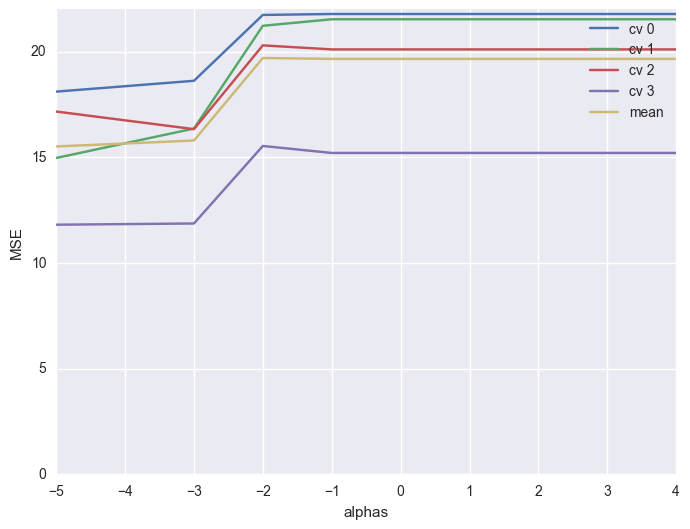

In [31]:
X_sc, y_data, X_data = preprocess(df)
pick_alpha(4, X_sc, y_data)

# Alpha
- It seems like 1e-3 is the best value
- Now, let's take a look at the strongest features

In [33]:
# Take a quick look at our strongest features
def find_features(alpha, X, y, columns):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    est=Lasso(alpha=alpha)
    est.fit(X_train,y_train)
    zipped=zip(columns,est.coef_)
    features=sorted(zipped,key = lambda t: t[1],reverse=True)
    print(est.score(X_test, y_test))
    return [x for x in features if x[1] != 0] ,est
def print_summary (features, X, y):
    features = [x[0] for x in features]
    X_features = X[features]
    lsm = sm.OLS(y,X_features)
    fit = lsm.fit()
    fit.summary()


In [42]:
features,est = find_features(1e-5, X_sc, y_data, X_sc.columns)

0.242136498339


/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [43]:
features

[('college[T.University of California, Los Angeles]', 849.83641509101278),
 ('trb_per_g', 664.30008796828099),
 ('wingspan_in', 427.17689518851381),
 ('stl', 52.349697829959879),
 ('draft_year', 50.471780736154031),
 ('ft', 41.931843387383147),
 ('fg', 39.546346377657031),
 ('blk', 29.372849755227051),
 ('weight_lb', 28.333037351587098),
 ('pts', 27.782114219441262),
 ('fg3', 17.902667316702686),
 ('ast', 13.814351840790962),
 ('mp', 5.5122987684376534),
 ('fg3a', -18.5223697591085),
 ('fga', -34.156880820078271),
 ('fta', -45.084158678215317),
 ('ast_per_g', -69.195495974364448),
 ('college[T.Iowa State University]', -88.018435167419213),
 ('reach_in', -91.046253823056318),
 ('g', -145.64594889424595),
 ('draft_rank', -209.23378620989499),
 ('mp_per_g', -349.02719051344371),
 ('college[T.University of Arizona]', -662.15741233596657),
 ('height_in', -742.34196071310691),
 ('start_age', -898.6472412032989),
 ('end_age', -1542.1085094536431)]

In [54]:
f = [x[0] for x in features]
X_sc, y_data, X_data = preprocess(df, cols=f)
lsm = sm.OLS(list(y_data),X_sc)
fit = lsm.fit()
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     1166.
Date:                Wed, 25 Jan 2017   Prob (F-statistic):               0.00
Time:                        15:59:33   Log-Likelihood:                -3373.2
No. Observations:                1220   AIC:                             6768.
Df Residuals:                    1209   BIC:                             6825.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
stl           50.8163     11.892      4.273      0.000        27.484    74.148
pts           43.9289      5.599      7.846      0.000        32.944    54.913
blk           25.0226      6.499      3.850      0.000        12.272    37.773
draft_year    13.4369      0.540     24.896      0.000        12.378    14.496
ast            9.3908      4.172      2.251      0.025         1.206    17.576
mp             7.2420      0.713     10.157      0.000         5.843     8.641
fg3a         -17.1836      3.265     -5.263      0.000       -23.589   -10.778
fta          -25.0458      6.129     -4.087      0.000       -37.070   -13.022
fga          -32.1872      6.127     -5.253      0.000       -44.208   -20.166
g           -154.8834     21.256     -7.287      0.000      -196.586  -113.181
draft_rank  -262.3532     26.554     -9.880      0.000      -314.449  -210.257
==============================================================================
Omnibus:                      513.578   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6126.432
Skew:                          -1.610   Prob(JB):                         0.00
Kurtosis:                      13.495   Cond. No.                         256.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Second Iteration
- Aim: cut more features!

/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


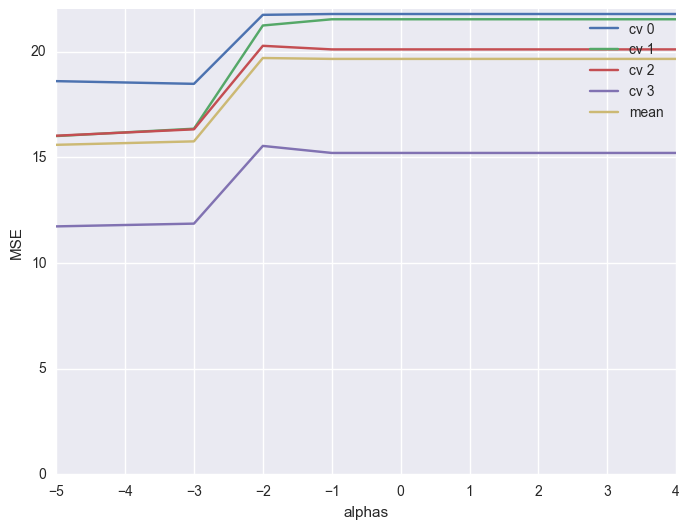

In [48]:
X_sc, y_data, X_data = preprocess(df, cols=f)
pick_alpha(4, X_sc, y_data)

- Observations:
    - Seems like 1e-3 is still the best alpha
    - Alternative approach: will remove features that could have multicollinearity.

In [55]:
correlated = []
cor = df[X_sc.columns].corr()
for col in cor.columns:
    correlated.append((col, cor[col].nlargest(2).index[1],
                      cor[col].nlargest(2).values[1]))

In [56]:
correlated

[('stl', 'ast', 0.72506690864110879),
 ('pts', 'fga', 0.97508250046589329),
 ('blk', 'fta', 0.28376206512199315),
 ('draft_year', 'fg3a', 0.058323579448395869),
 ('ast', 'stl', 0.72506690864110879),
 ('mp', 'pts', 0.74396985880578403),
 ('fg3a', 'fga', 0.54102834032623237),
 ('fta', 'pts', 0.83630938455268378),
 ('fga', 'pts', 0.97508250046589329),
 ('g', 'mp', 0.73547185323270137),
 ('draft_rank', 'g', 0.2426616425821998)]

**Observations**
- Correlated values: pts and fga, stl and ast, g and mp
- Will choose mp over g, because we have more continuity in mp 

**Strategy**
- See which values to keep: stl or ast, and pts or fgs


In [57]:
def basic_plot(x_col, y_col, df, ax, x_label=None, y_label=None):
    if not x_label:
        x_label = x_col 
    if not y_label:
        y_label = y_col
    ax.scatter(df[x_col], df[y_col], label=y_label)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title('{} vs. {}'.format(x_label, y_label))
    

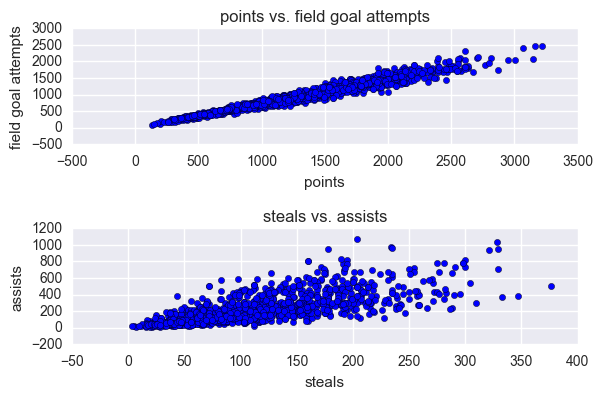

In [58]:
fig,ax = plt.subplots(2,1)
plt.figure(figsize=(10,10))
fig.tight_layout(pad=2, h_pad=4)
basic_plot('pts', 'fga', df, ax[0], 'points', 'field goal attempts')
basic_plot('stl', 'ast', df, ax[1], 'steals', 'assists')

Correlation with pts:0.0011846709769477728
Correlation with fga:-0.041864287858838715


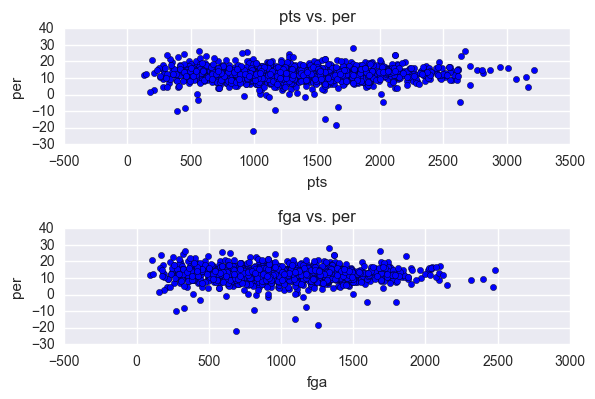

In [59]:
fig,ax = plt.subplots(2,1)
plt.figure(figsize=(10,10))
fig.tight_layout(pad=2, h_pad=4)
basic_plot('pts', 'per', df, ax[0])
basic_plot('fga', 'per', df, ax[1])
print('Correlation with pts:{}'.format(df.corr()['per']['pts']))
print('Correlation with fga:{}'.format(df.corr()['per']['fga']))

**Observations**
- Will take points over field goal attemps. 
- It has a better correlation with PER

Correlation with stl:0.005156514504210606
Correlation with ast:-0.03698579140972004


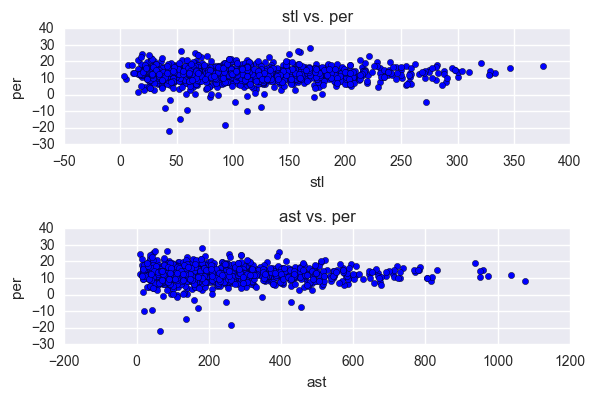

In [60]:

fig,ax = plt.subplots(2,1)
plt.figure(figsize=(10,10))
fig.tight_layout(pad=2, h_pad=4)
basic_plot('stl', 'per', df, ax[0])
basic_plot('ast', 'per', df, ax[1])
print('Correlation with stl:{}'.format(df.corr()['per']['stl']))
print('Correlation with ast:{}'.format(df.corr()['per']['ast']))

# Conclusion
- Remove g, ast, and fga
- Will remove draft year too because it's discrete values and it might mess up the data.
# Third Iteration

/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


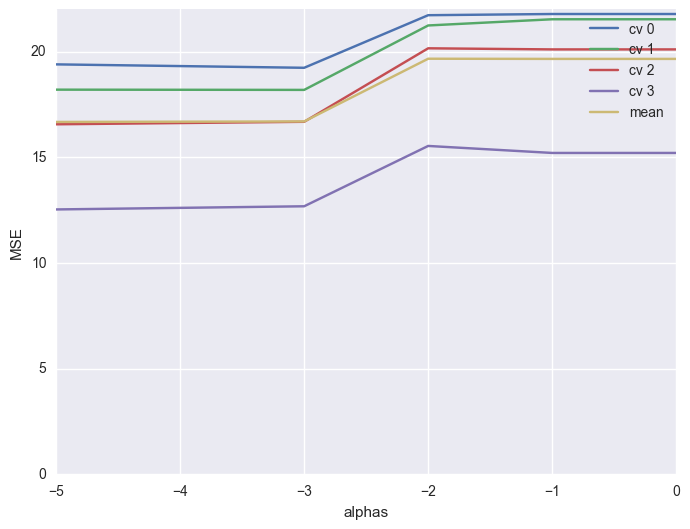

In [61]:
cols_2 = list(set(f) - set(['g', 'ast', 'fga']))
X_sc, y_data, X_data = preprocess(df, cols=cols_2)
pick_alpha(4, X_sc, y_data, alphas=[1e-5,1e-3,1e-2, 1e-1,1])

In [62]:
# Use new alpha value of 1e-7
features_2, est = find_features(1e-3, X_sc, y_data, X_sc.columns)
f = [x[0] for x in features_2]
X_sc, y_data, X_data = preprocess(df, cols=f)
lsm = sm.OLS(list(y_data),X_sc)
fit = lsm.fit()
fit.summary()

0.279385359257


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     1703.
Date:                Wed, 25 Jan 2017   Prob (F-statistic):               0.00
Time:                        15:59:58   Log-Likelihood:                -3415.4
No. Observations:                1220   AIC:                             6845.
Df Residuals:                    1213   BIC:                             6881.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
stl           36.3605      9.770      3.721      0.000        17.192    55.529
draft_year    12.9162      0.537     24.050      0.000        11.863    13.970
pts            7.3514      1.246      5.902      0.000         4.908     9.795
blk            4.6833      5.727      0.818      0.414        -6.552    15.919
mp             6.3606      0.642      9.911      0.000         5.102     7.620
fg3a         -13.3779      2.800     -4.779      0.000       -18.870    -7.885
draft_rank  -355.1963     23.587    -15.059      0.000      -401.473  -308.920
==============================================================================
Omnibus:                      443.855   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4284.642
Skew:                          -1.400   Prob(JB):                         0.00
Kurtosis:                      11.743   Cond. No.                         201.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
features_2

[('stl', 31.898516099149969),
 ('draft_year', 5.1199456780712467),
 ('blk', 5.0833141223943725),
 ('pts', 3.8363071786652174),
 ('fta', -3.6922176654369649),
 ('fg3a', -14.803231157098798),
 ('draft_rank', -311.22639695071854)]

In [44]:
features

[('stl', 42.19867010535603),
 ('pts', 32.661240189428177),
 ('blk', 15.48997226069196),
 ('draft_year', 7.2905058253273802),
 ('ast', 4.3419697796347121),
 ('mp', 1.7875607870723269),
 ('fg3a', -12.957081635324416),
 ('fta', -13.297960435312937),
 ('fga', -28.046602351127653),
 ('g', -113.12278475183122),
 ('draft_rank', -256.42387806622804)]

In [39]:
def diagnostic_plot(x, y, title):
    s = len(x)
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x.reshape(s,1),y)
    pred = rgr.predict(x.reshape(s,1))

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel(title)
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [67]:
for feature in f:
    diagnostic_plot(X_sc[feature], y_data, feature)

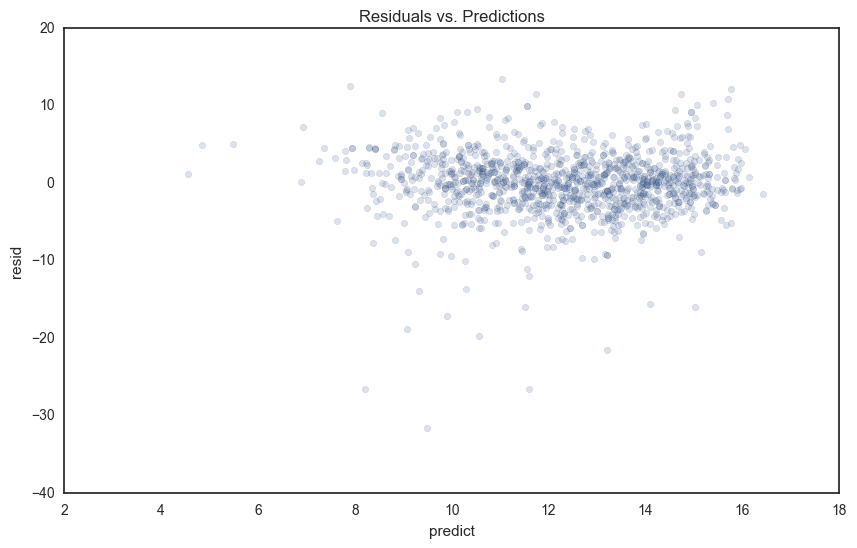

In [42]:
# develop OLS with Sklearn
df['predict']=fit.predict(X_sc)
df['resid']=df.per-df.predict
with sns.axes_style('white'):
    plot=df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))
plt.title('Residuals vs. Predictions')

In [71]:
df_college = df.groupby('college')['college'].count()

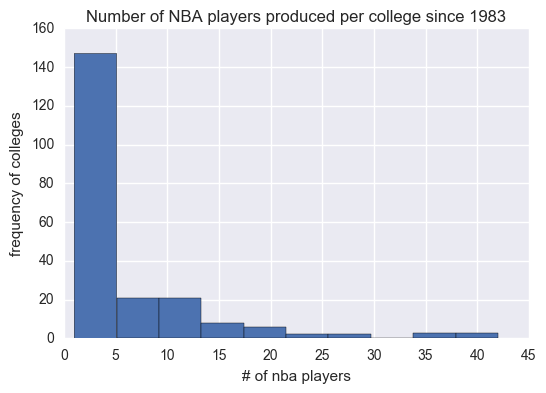

In [78]:
df_college.hist()
plt.title('Number of NBA players produced per college since 1983')
plt.ylabel('frequency of colleges')
plt.xlabel('# of nba players')

In [77]:
df.draft_year.min()

1983.0